
###Выполнил Мусаев Руслан

##3.       Классификация вредоносного поведения.
 
Описание колонок в файле:
 
tag - классификатор, имеет значение 0, если процесс обычный, и 1, если процесс вредоносный.
 
Имена остальных колонок (их более 800!) совпадают с именами изменяемых ключей реестра, файлов, загружаемых библиотек и системных вызовов.
В строках для этих колонок содержится количество действий (изменений/загрузок/вызовов).
 
Ваша задача:
1.       Оценить важность различных признаков, оставить наиболее информативные.
2.       Реализовать одну или несколько моделей, классифицирующих вредоносное поведение.  Оценить точность модели.


In [33]:
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1fJ5VNX_6xY5yI7g1FkqrVNcFRzLecDy9" -o 'behavior.csv'
import pandas as pd
data = pd.read_csv('/content/behavior.csv')
data.head(5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    149      0 --:--:--  0:00:02 --:--:--   149
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 85.1M    0 85.1M    0     0  22.2M      0 --:--:--  0:00:03 --:--:--  174M


,Unnamed: 0,hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\mobileoptionpack,hkey_classes_root\\clsid\{148bd52a-a2ab-11ce-b11f-00aa00530503},hkey_current_user\\software\microsoft\windows\currentversion\urlmon settings,hkey_local_machine\\system\currentcontrolset\services\tcpip\parameters\interfaces\ms tcp loopback interface,hkey_local_machine\\software\microsoft\net framework setup\ndp\v3.5,hkey_local_machine\\software\microsoft\windows nt\currentversion\winlogon,hkey_local_machine\\software\microsoft\windows\currentversion\internet settings\user agent,hkey_local_machine\\system\currentcontrolset\services\dnscache\parameters,hkey_current_user\\software\microsoft\windows\currentversion\explorer\mountpoints2\cpc\volume,hkey_local_machine\\system\currentcontrolset\control\nls\codepage,hkey_local_machine\\software\microsoft\internet explorer\security\floppy access,hkey_local_machine\\software\policies\microsoft\windows\currentversion\internet settings\zonemap\,hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\schedulingagent,hkey_local_machine\\software\microsoft\cryptography\defaults\provider types\type 024,hkey_local_machine\\system\currentcontrolset\services\tcpip\parameters,hkey_classes_root\\.com,hkey_local_machine\\software\microsoft\windows script\features,hkey_local_machine\\software\microsoft\ctf\dimm12,hkey_current_user\\software\microsoft\windows\currentversion\explorer\desktop\namespace,hkey_current_user\\software\microsoft\windows\currentversion\internet settings\user agent,hkey_classes_root\\clsid\{a5e46e3a-8849-11d1-9d8c-00c04fc99d61},hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\fontcore,hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\ie5bakex,hkey_local_machine\\software\microsoft\internet explorer,hkey_current_user\\keyboard layout\toggle,hkey_classes_root\\clsid\{1b1cad8c-2dab-11d2-b604-00104b703efd},hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\iedata,hkey_current_user\\software\policies\microsoft\windows\currentversion\internet settings\zonemap\,hkey_local_machine\\software\microsoft\internet explorer\toolbar,hkey_local_machine\\software\microsoft\windows\currentversion\run,hkey_local_machine\\software\microsoft\windows,hkey_current_user\\software\policies\microsoft\windows\currentversion\internet settings\lockdown_zones\0,hkey_local_machine\\software\microsoft\windows\currentversion\policies\ratings,hkey_current_user\\software\policies\microsoft\windows\currentversion\internet settings\zones\2,hkey_current_user\\software\policies\microsoft\windows\currentversion\internet settings\lockdown_zones\,hkey_local_machine\\software\policies\microsoft\windows\system,hkey_classes_root\\protocols\name-space handler\c\,hkey_local_machine\\software\microsoft\ctf\tip,hkey_current_user\\software\microsoft\internet explorer,...,c:\windows\system32\winmm.dll,c:\windows\system32\advapi32.dll,c:\windows\system32\netapi32.dll,conout$,c:\windows\system32\l_intl.nls,c:\windows\assembly\gac_32\mscorlib\2.0.0.0__b77a5c561934e089\mscorlib.dll,c:\windows\assembly\gac_32\mscorlib\2.0.0.0__b77a5c561934e089\sorttbls.nlp,c:\documents and settings\username\application data\microsoft\clr security config\v2.0.50727.42\security.config.cch,\\.\physicaldrive,c:\documents and settings\username\local settings\application data\gdipfontcachev1.dat,c:\windows\assembly\gac_msil\system.configuration\2.0.0.0__b03f5f7f11d50a3a\system.configuration.dll,c:\windows\system32\crypt32.dll,c:\windows\system32\msiexec.exe.config,c:\python27\pythonw.exe,\\.\pipe,c:\windows\system32\msimsg.dll,c:\windows\system32\uxtheme.dll,c:\windows\system32\wbem\logs\wbemprox.log,c:\python27\lib\site-packages\pythonwin\pythonwin.exe,c:\program files\ga\virtualbox guest additions\vboxdrvinst.exe,c:\documents and settings\username\local settings\application data\google\chrome\chrome.exe,c:\program files\ga\virtualbox guest additions\vboxtray.exe,c:\windows\s

In [34]:
#будем работать только с числовыми признаками
data.drop(data.columns[0], axis=1, inplace = True)
gt = data[data.columns[-1]]
data.drop(data.columns[-1], axis=1, inplace = True)

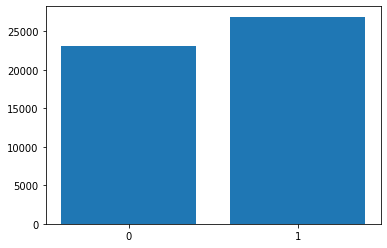

In [37]:
#посмотрим на распределение классов
import matplotlib.pyplot as plt
zeros = (gt == 0).sum()
ones = (gt == 1).sum()
x = [0,1]
y = [zeros, ones]
fig, ax = plt.subplots()
plt.xticks(x)
ax.bar(x, y)
plt.show()

###1.Оценить важность различных признаков, оставить наиболее информативные.

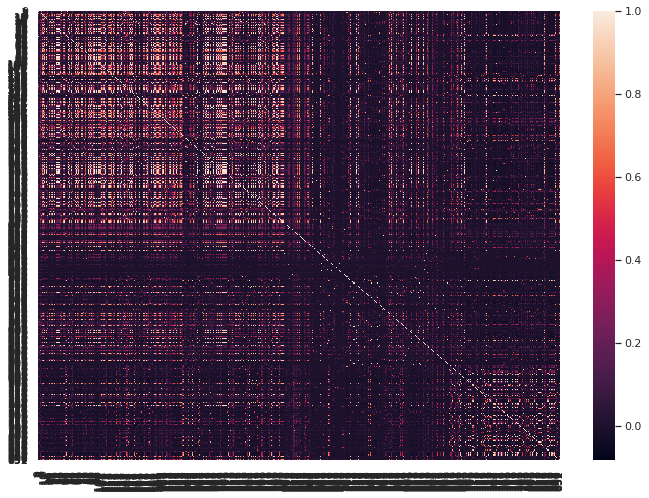

In [43]:
#посмотрим на корреляцию исходных признаков (ячейка долго работает!)
import seaborn as sns
import numpy as np

corr = data.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, xticklabels = np.arange(data.shape[1]), yticklabels = np.arange(data.shape[1]));

In [44]:
#уменьшим пространство признаков с помощью PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 30)
data_centered = data - data.mean(axis = 0)
pca.fit(data_centered)

#Спроектируем пространство на пространство главных компонент
data_pca = pca.transform(data_centered)
print(data_pca.shape)

(50000, 30)


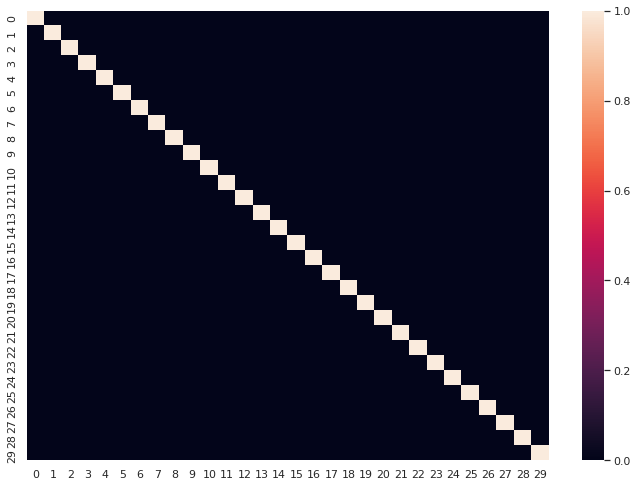

In [45]:
data_pca_pd = pd.DataFrame(data_pca)
corr = data_pca_pd.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns);

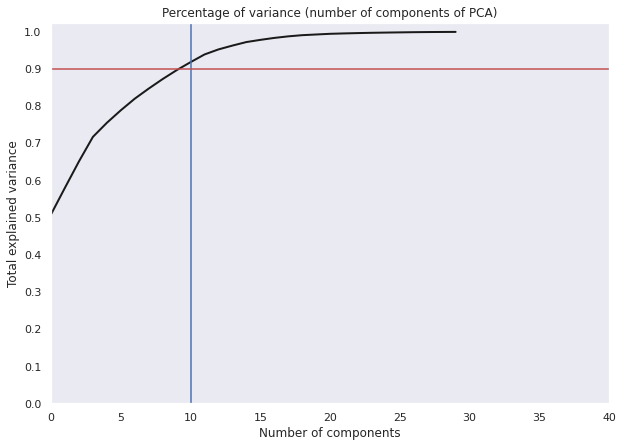

In [47]:
#Посмотрим на процент дисперсий по главным компонентам
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.title('Percentage of variance (number of components of PCA)')
plt.xlim(0, 40)
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))

sigma = [i for i, j in enumerate(list(np.cumsum(pca.explained_variance_ratio_) >= 0.9)) if j == True][0] #90% дисперсии исходных данных содержатся в пространстве 10 главных компонент

plt.axvline(sigma, c='b')
plt.axhline(0.9,c='r',)
plt.show();

###2.Реализовать одну или несколько моделей, классифицирующих вредоносное поведение. Оценить точность модели.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
scaler.fit(data_pca)
data_pca = scaler.transform(data_pca)

X_train, X_test, y_train, y_test = train_test_split(data_pca, gt, test_size=.3, stratify=gt, random_state=42)

###Decision Tree Model

In [50]:
#Разделим выборки, используем классификатор на основе решающего дерева
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

model = DecisionTreeClassifier(max_depth = 15, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.64%


###LogisticRegression

In [51]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, max_iter = 1000,)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.23%


###XGBoost classifier

In [52]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.93%
